### General idea

The neural signals, as well as forces, cursors and trial information (time for trial start, gocue, trial end, target directions, target results) during experiments, were saved by Cerebus system in .nev files. These .nev files could be loaded by the `xds` structure in both MATLAB and Python. During the brain control blocks, the binned spikes and the predicted cursor trajectories were saved in `.txt` files. As we noticed before, the cursor trajectories saved in the .nev file may not be accurate, so we would trust the cursors saved in the `.txt` files more. The codes below demonstrate how to load the data in the `.txt` files and extract trial information from the corresponding `xds` files.

#### Add xds to your Python path

In [1]:
import sys
sys.path.append('d:/onedrive/codes/xds/')

#### Functions

In [2]:
import numpy as np
from xds import lab_data
import os, fnmatch

def get_trial_data_from_txt(base_path, xds_file, spike_file, cursor_file, time_params, bin_size = 0.05):
    """
    This function is designed to load data from paired xds and txt files.
    
    INPUTS:
    base_path: a string, specifying the path to the data files.
    xds_file: a string, the file name of the xds file to be loaded.
    spike_file: a string, the file name of the spike txt file to be loaded.
    cursor_file: a string, the file name of the cursor txt file to be loaded.
    time_params: a dictionary, see the example below.
    bin_size: a number specifying the bin size, should be 0.05 for all the monkey data used in this study
    
    OUTPUTS:
    A dictionary containing all the necessary. The names of the fields are self-explanatory. The data type of each field
    is either numpy array or list.
    """
    def adjust_idx_len(a, c):
        if c != 0:
            if len(a)>c:
                a = a[:c]
            elif len(a)<c:
                a = np.append(a, np.arange(a[-1]+1, a[-1]+c-len(a)+1))
        return a
    
    # ------- Read the xds file to get the trial information -------- #
    if base_path[-1] != '/':
        base_path = base_path + '/'
    dataset = lab_data(base_path + 'xds/', xds_file)
    common_len = 0 # In some cases the length may have slightly different, this variable is for correction
    
    # ------- Find out trial information ------ #
    trial_result = dataset.trial_result
    trial_target_dir = dataset.trial_target_dir
    trial_start_time = dataset.trial_start_time
    trial_gocue_time = dataset.trial_gocue_time
    trial_end_time = dataset.trial_end_time
    trial_target_corners = dataset.trial_target_corners
    
    # -------- Get rid of trials with gocue time nan -------- #
    gocue_nan_idx = np.argwhere(np.isnan(trial_gocue_time))[:,0]
    start_nan_idx = np.argwhere(np.isnan(trial_start_time))[:,0]
    end_nan_idx = np.argwhere(np.isnan(trial_end_time))[:,0]
    union_nan_idx = np.asarray(sorted(list(set(gocue_nan_idx).union(set(start_nan_idx)).union(set(end_nan_idx))),
                                      reverse = True))
    if len(union_nan_idx)>0:
        trial_gocue_time = np.delete(trial_gocue_time, union_nan_idx)
        trial_start_time = np.delete(trial_start_time, union_nan_idx)
        trial_end_time = np.delete(trial_end_time, union_nan_idx)
        trial_result = np.delete(trial_result, union_nan_idx)
        trial_target_dir = np.delete(trial_target_dir, union_nan_idx)
        trial_target_corners = np.delete(trial_target_corners, union_nan_idx, axis = 0)
    
    # ------- Find out the behavior time stamps ------ #
    if time_params['start_event'] == 'gocue_time':
        t1 = trial_gocue_time-time_params['time_before_start']
    elif time_params['start_event'] == 'start_time':
        t1 = trial_start_time-time_params['time_before_start']
    elif time_params['start_event'] == 'end_time':
        t1 = trial_end_time-time_params['time_before_start']

    if time_params['end_event'] == 'gocue_time':
        t2 = trial_gocue_time+time_params['time_after_end']
    elif time_params['end_event'] == 'start_time':
        t2 = trial_start_time+time_params['time_after_end']
    elif time_params['end_event'] == 'end_time':
        t2 = trial_end_time+time_params['time_after_end']  
    
    if time_params['start_event'] == time_params['end_event']:
        common_len = int(np.ceil((time_params['time_before_start']+time_params['time_after_end'])/bin_size))
    
    # ------- Read the txt files for data storage ------ #
    spike_time = np.loadtxt(base_path + 'spike txt/' + spike_file)[:, 0]
    spike_counts = np.loadtxt(base_path + 'spike txt/' + spike_file)[:, 1:]*bin_size
    
    cursor_time = np.loadtxt(base_path + 'cursor txt/' + cursor_file)[:, 0]
    cursor = np.loadtxt(base_path + 'cursor txt/' + cursor_file)[:, 1:]
    
    bad_trial_idx = [] # In the .txt file, sometimes there may be missing time points. This variable record the index of these trials
    trial_spike, trial_cursor, trial_emgpreds = [], [], []
    for i, t in enumerate(zip(t1, t2)):        
        idx = np.where((spike_time>t[0])&(spike_time<=t[1]))[0]
        idx = adjust_idx_len(idx, common_len)
        dt = np.diff(spike_time[idx])
        if len(np.where(dt>2*0.05)[0])>0:
            bad_trial_idx.append(i) # Record the bad trials here, and delete them post-hoc
        trial_spike.append(spike_counts[idx, :])
        idx = np.where((cursor_time>t[0])&(cursor_time<t[1]))[0]
        idx = adjust_idx_len(idx, common_len)
        trial_cursor.append(cursor[idx, :])
    
    bad_trial_idx = np.asarray(sorted(bad_trial_idx, reverse = True))
    if len(bad_trial_idx)>0:
        trial_gocue_time = np.delete(trial_gocue_time, bad_trial_idx)
        trial_start_time = np.delete(trial_start_time, bad_trial_idx)
        trial_end_time = np.delete(trial_end_time, bad_trial_idx)
        trial_result = np.delete(trial_result, bad_trial_idx)
        trial_target_dir = np.delete(trial_target_dir, bad_trial_idx)
        trial_target_corners = np.delete(trial_target_corners, bad_trial_idx, axis = 0)

    for idx in bad_trial_idx:
        del(trial_spike[idx])
        del(trial_cursor[idx])
    del(dataset)
    return{
        'result': trial_result,
        'target_dir': trial_target_dir,
        'spike': trial_spike,
        'cursorpos': [each[:, :2] for each in trial_cursor],
        'cursorvel': [each[:, 2:] for each in trial_cursor],
        'start_time':trial_start_time,
        'gocue_time': trial_gocue_time,
        'end_time': trial_end_time,
        'target_corners': [list(each) for each in trial_target_corners]
        }

#### An example of using the function above

There are many files in one experiment, and they should be saved under the `base_path`. Fist, we scan all the files under the `base_path`, and put the file names in three lists according to their type. After this, we print them out and take a double check at the time stamp in the file names. The files from the same brain control testing block should have the same time stamp.

At the same time, we use a list named `decoder_type` to store the type of the brain control decoder used in each block.

In [3]:
base_path = 'F:/DS/20240110/brain control files/'
xds_list = np.sort(fnmatch.filter(os.listdir(base_path + 'xds/'), "*.mat"))
spike_txt_list = np.sort(fnmatch.filter(os.listdir(base_path + 'spike txt/'), "*.txt"))
cursor_txt_list = np.sort(fnmatch.filter(os.listdir(base_path + 'cursor txt/'), "*.txt"))
"""
With the use of np.sort and fnmatch the file names were sort according to the time stamp in the file name strings
"""
decoder_type = []

print('Double check the timestamp in file names to see if they are correctly paired')
for i in range(len(xds_list)):
    print('=========================================================')
    print(xds_list[i])
    print(spike_txt_list[i])
    print(cursor_txt_list[i])
    if 'Wiener' in cursor_txt_list[i]:
        decoder_type.append('WF')
    elif 'MultiNomial' in cursor_txt_list[i]:
        decoder_type.append('DS')
print('')
print('==============The type of the decoder used===============')
print(decoder_type)

Double check the timestamp in file names to see if they are correctly paired
20240110_1415_Tot_WS_002.mat
Tot_20240110_1415_WS_Spikes.txt
Tot_20240110_1415_WS_MultiNomial_RewardCursor.txt
20240110_1419_Tot_WS_003.mat
Tot_20240110_1419_WS_Spikes.txt
Tot_20240110_1419_WS_WienerCursor.txt
20240110_1422_Tot_WS_004.mat
Tot_20240110_1422_WS_Spikes.txt
Tot_20240110_1422_WS_MultiNomial_RewardCursor.txt
20240110_1426_Tot_WS_005.mat
Tot_20240110_1426_WS_Spikes.txt
Tot_20240110_1426_WS_WienerCursor.txt
20240110_1429_Tot_WS_006.mat
Tot_20240110_1429_WS_Spikes.txt
Tot_20240110_1429_WS_MultiNomial_RewardCursor.txt
20240110_1433_Tot_WS_007.mat
Tot_20240110_1433_WS_Spikes.txt
Tot_20240110_1433_WS_WienerCursor.txt
20240110_1437_Tot_WS_008.mat
Tot_20240110_1437_WS_Spikes.txt
Tot_20240110_1437_WS_MultiNomial_RewardCursor.txt
20240110_1440_Tot_WS_009.mat
Tot_20240110_1440_WS_Spikes.txt
Tot_20240110_1440_WS_WienerCursor.txt
20240110_1444_Tot_WS_010.mat
Tot_20240110_1444_WS_Spikes.txt
Tot_20240110_1444_WS_M

Now everythin is ready so we can load the data from one testing block. The variable `BLOCK_NUM` specifies which block we want to look at. The dictionary `time_params` specifies the time period we are interested in each trial. 

In [7]:
BLOCK_NUM = 2
time_params = {'start_event': 'gocue_time', 'time_before_start': 0.0, 
                        'end_event': 'end_time', 'time_after_end': 0}
trial_data = get_trial_data_from_txt(base_path, xds_list[BLOCK_NUM], spike_txt_list[BLOCK_NUM], cursor_txt_list[BLOCK_NUM], 
                                 time_params, bin_size = 0.05)

Trials with nan timings have been removed!


#### Extracting the target corners for plotting

Since there are only 8 targets in the experiments, here we extract the coordinates of them first.

In [8]:
target_corners = []
for each in trial_data['target_corners']:
    if each in target_corners:
        continue
    else:
        target_corners.append(each)
    if len(target_corners)>8:
        break

Here let's plot the cursor trajectories using the data extracted above. Please check the `NOTE` in the comments to avoid potential troubles due to data corruption.

(-12.0, 12.0, -12.0, 12.0)

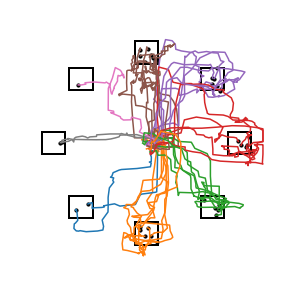

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.patches as patches

idx = np.where(trial_data['result']=='R')[0] # the indices for all successful trials in one testing block 
target_dir_list = [-135, -90, -45, 0, 45, 90, 135, 180]# a predefined list for the directions of the targets
cm = plt.get_cmap('tab10')

fig = plt.figure('mn suc', figsize = (5, 5))
ax = plt.subplot(111)
for each in idx:
    try:
        color_index = target_dir_list.index(trial_data['target_dir'][each])
        # NOTE: sometimes the trial_data['target_dir'] may contain an invalid value and may cause troubles.
        # By this exception handling we can skip such troubles.
        c = cm(color_index)
    except Exception:
        continue
    plt.plot(trial_data['cursorpos'][each][:, 0], trial_data['cursorpos'][each][:, 1], color = c)
    plt.scatter(trial_data['cursorpos'][each][-1, 0], trial_data['cursorpos'][each][-1, 1], color = 'k', s = 10)

for each in target_corners:
    x1,y1,x2,y2 = each[0], each[1], each[2], each[3]
    ax.add_patch(patches.Rectangle((x1,y1), x2 - x1, y2 - y1, linewidth=2,edgecolor='k',facecolor='none'))
    
plt.ylim([-12, 12])
plt.xlim([-12, 12])
plt.axis('off')
